<a href="https://colab.research.google.com/github/0-lingual/Deepfake-Detection-using-CNN/blob/main/best_accuracy_ad1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning을 이용한 이미지 분류기(Dataset2)**

In [ ]:
# Kaggle API 설치
!pip install kaggle

# Kaggle API 토큰 업로드
from google.colab import files
files.upload()  # 여기서 kaggle.json 파일을 업로드합니다.

# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 데이터셋 다운로드
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# 압축 해제
!unzip -o deepfake-and-real-images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  
  inflating: D

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from pathlib import Path
import pandas as pd
import os

def image_to_df(filepaths):
  # Extract the labels from the filepaths
  labels = [str(filepath).split(".")[-2].split("/")[-1].split("_")[0] for filepath in filepaths]

  # Create a pandas Series for the filepaths and labels
  filepath = pd.Series(filepaths, name='Data').astype(str)
  labels = pd.Series(labels, name='Label')

  # Combine the Series into a DataFrame
  df = pd.concat([filepath, labels], axis=1)

  return df

# Set the data path
data_path = "/content/Dataset"

# Get the paths to the Train, Test, and Validation directories
train_path = os.path.join(data_path, "Train")
test_path = os.path.join(data_path, "Test")
val_path = os.path.join(data_path, "Validation")

# Get the paths to the Real and Fake directories within each of the above directories
train_real_path = os.path.join(train_path, "Real")
train_fake_path = os.path.join(train_path, "Fake")
test_real_path = os.path.join(test_path, "Real")
test_fake_path = os.path.join(test_path, "Fake")
val_real_path = os.path.join(val_path, "Real")
val_fake_path = os.path.join(val_path, "Fake")

# Get the filepaths for all the images in each of the Real and Fake directories
train_real_filepaths = list(Path(train_real_path).glob(r'**/*.jpg'))
train_fake_filepaths = list(Path(train_fake_path).glob(r'**/*.jpg'))
test_real_filepaths = list(Path(test_real_path).glob(r'**/*.jpg'))
test_fake_filepaths = list(Path(test_fake_path).glob(r'**/*.jpg'))
val_real_filepaths = list(Path(val_real_path).glob(r'**/*.jpg'))
val_fake_filepaths = list(Path(val_fake_path).glob(r'**/*.jpg'))

# Combine the filepaths into a single list
filepaths = train_real_filepaths + train_fake_filepaths + test_real_filepaths + test_fake_filepaths + val_real_filepaths + val_fake_filepaths

df = image_to_df(filepaths)

In [ ]:
# @title 데이터와 라벨 확인
print(f'Number of training pictures : {df.shape[0]}\n')
print(f'Number of training labels : {df.shape[1]}\n')

Number of training pictures : 190335

Number of training labels : 2



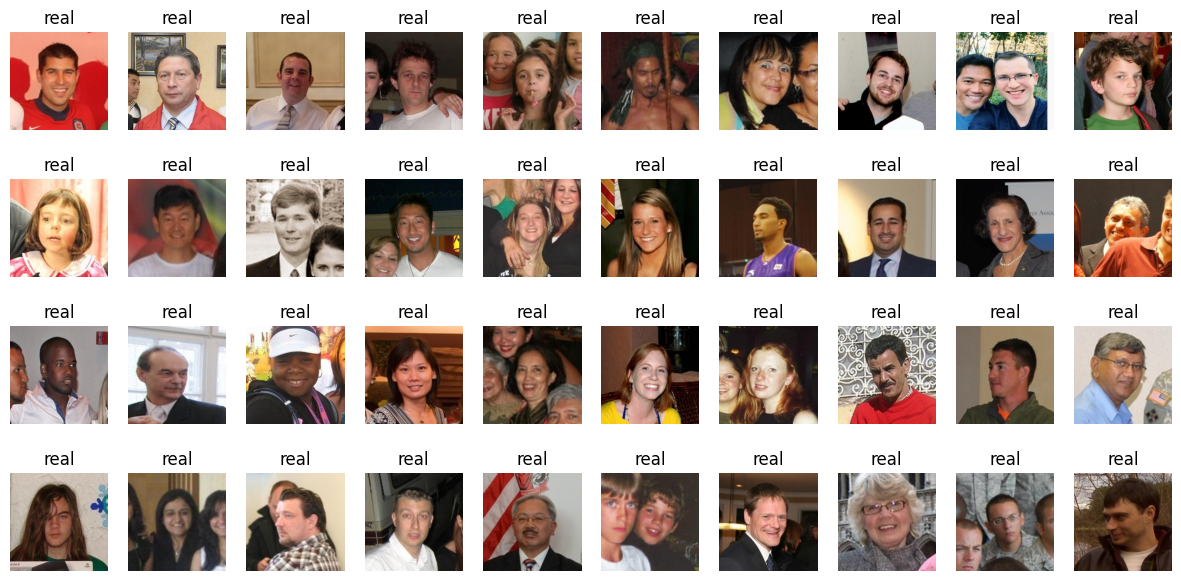

In [ ]:
import matplotlib.pyplot as plt

# @title train data 출력
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df['Data'].iloc[i]))
  ax.set_title(df['Label'].iloc[i])
  ax.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# @title train, test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)
train_df.shape, test_df.shape

((171301, 2), (19034, 2))

In [ ]:
# @title 학습에 필요한 데이터 생성
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(train_df, x_col='Data', y_col='Label',
                                        target_size=(256,256), class_mode='binary', batch_size=64, shuffle=True, subset='training')
val_gen = datagen.flow_from_dataframe(train_df, x_col='Data', y_col='Label',
                                      target_size=(256,256), class_mode='binary', batch_size=64, shuffle=False, subset='validation')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='Data', y_col='Label',
                                            target_size=(256,256), class_mode='binary', batch_size=64, shuffle=False)

Found 137041 validated image filenames belonging to 2 classes.
Found 34260 validated image filenames belonging to 2 classes.
Found 19034 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf

cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 64)                33032256  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [ ]:
# @title model 학습
history = cnn.fit(x=train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
2142/2142 [==============================] - 1282s 598ms/step - loss: 0.4539 - accuracy: 0.7820 - val_loss: 0.3920 - val_accuracy: 0.8207
Epoch 2/10
2142/2142 [==============================] - 1295s 604ms/step - loss: 0.3345 - accuracy: 0.8506 - val_loss: 0.3519 - val_accuracy: 0.8462
Epoch 3/10
2142/2142 [==============================] - 1298s 606ms/step - loss: 0.2413 - accuracy: 0.8965 - val_loss: 0.3624 - val_accuracy: 0.8549
Epoch 4/10
2142/2142 [==============================] - 1302s 608ms/step - loss: 0.1680 - accuracy: 0.9312 - val_loss: 0.3734 - val_accuracy: 0.8586
Epoch 5/10
2142/2142 [==============================] - 1313s 613ms/step - loss: 0.1218 - accuracy: 0.9520 - val_loss: 0.4114 - val_accuracy: 0.8633
Epoch 6/10
 889/2142 [===========>..................] - ETA: 11:45 - loss: 0.0900 - accuracy: 0.9673

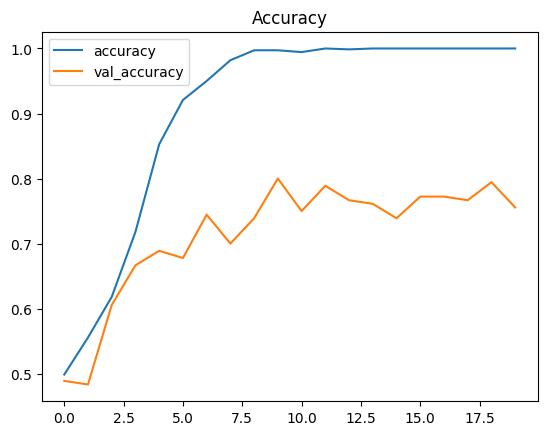

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# **data augmentation으로 모델 성능 높이기**

In [ ]:
def create_gen():
  train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
      validation_split=0.2
  )

  test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

  train_image = train_generator.flow_from_dataframe(
      dataframe=train_df, x_col="Data", y_col="Label", target_size=(224,224), class_mode='binary',
      rescale=1./255, vertical_flip=True, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
      fill_mode="nearest", subset='training', batch_size=32, shuffle=True)

  val_image = train_generator.flow_from_dataframe(
      dataframe=train_df, x_col="Data", y_col="Label", target_size=(224,224), class_mode='binary',
      rescale=1./255, vertical_flip=True, rotation_range=45, width_shift_range=0.2, height_shift_range=0.2,
      fill_mode="nearest", subset='validation', batch_size=32, shuffle=False
  )

  test_image = test_generator.flow_from_dataframe(
      dataframe=test_df, x_col='Data', y_col='Label', target_size=(224,224), class_mode='binary',
      shuffle=False, batch_size=32
  )

  return train_generator, test_generator, train_image, val_image, test_image

train_generator,test_generator,train_images,val_images,test_images = create_gen()

Found 137041 validated image filenames belonging to 2 classes.
Found 34260 validated image filenames belonging to 2 classes.
Found 19034 validated image filenames belonging to 2 classes.


In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[256, 256, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=1, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=16, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 123008)           

In [ ]:
history = cnn.fit(x=train_images, validation_data=val_images, epochs=10)

Epoch 1/10
48/48 [==============================] - 11s 199ms/step - loss: 0.6461 - accuracy: 0.6896 - val_loss: 0.5030 - val_accuracy: 0.8011
Epoch 2/10
48/48 [==============================] - 9s 183ms/step - loss: 0.3953 - accuracy: 0.8226 - val_loss: 0.4084 - val_accuracy: 0.8117
Epoch 3/10
48/48 [==============================] - 10s 199ms/step - loss: 0.3149 - accuracy: 0.8670 - val_loss: 0.3901 - val_accuracy: 0.8408
Epoch 4/10
48/48 [==============================] - 9s 195ms/step - loss: 0.2433 - accuracy: 0.9054 - val_loss: 0.4064 - val_accuracy: 0.8302
Epoch 5/10
48/48 [==============================] - 9s 178ms/step - loss: 0.1363 - accuracy: 0.9510 - val_loss: 0.4426 - val_accuracy: 0.8302
Epoch 6/10
48/48 [==============================] - 10s 202ms/step - loss: 0.0823 - accuracy: 0.9782 - val_loss: 0.3936 - val_accuracy: 0.8541
Epoch 7/10
48/48 [==============================] - 10s 208ms/step - loss: 0.0491 - accuracy: 0.9848 - val_loss: 0.5169 - val_accuracy: 0.8302
Ep

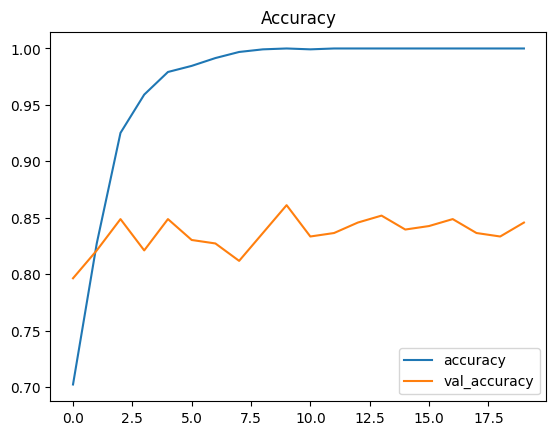

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

# **전이학습을 이용해 모델 성능 높이기**

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

def get_model(model):
  kwargs = {'input_shape' :(224, 224, 3),
            'include_top':False,
            'pooling':'avg'}
  pretrained_model = model(**kwargs)
  pretrained_model.trainable = False
  inputs = pretrained_model.input

  x = tf.keras.layers.Dense(units=32, activation='relu')(pretrained_model.output)
  x = tf.keras.layers.Dense(units=32, activation='relu')(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
  return model

In [ ]:
with tf.device('/device:GPU:0'):
  for name, model in models.items():

      # 전이 학습 모델 가져오기
      m = get_model(model['model'])
      models[name]['model'] = m

      start = perf_counter()

      # 모델 학습
      history = m.fit(train_images, validation_data=val_images, epochs=1,verbose=1)

      val_acc = history.history['val_accuracy']
      models[name]['val_acc'] = [round(v,4) for v in val_acc]

 631/4283 [===>..........................] - ETA: 31:34 - loss: 0.6481 - accuracy: 0.6234

KeyboardInterrupt: 

In [ ]:
# @title 성능확인
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = (pred > 0.5).astype(int).flatten()

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

16/16 [==============================] - 9s 416ms/step
**DenseNet121 has a 30.14% accuracy on the test set**
16/16 [==============================] - 5s 252ms/step
**MobileNetV2 has a 30.14% accuracy on the test set**
16/16 [==============================] - 6s 330ms/step
**InceptionV3 has a 30.14% accuracy on the test set**
16/16 [==============================] - 5s 294ms/step
**ResNet50 has a 30.14% accuracy on the test set**
16/16 [==============================] - 9s 568ms/step
**VGG16 has a 30.14% accuracy on the test set**
16/16 [==============================] - 7s 397ms/step
**Xception has a 30.14% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet121,0.8965,0.3014,0
1,MobileNetV2,0.8976,0.3014,0
2,InceptionV3,0.8725,0.3014,0
3,ResNet50,0.6830,0.3014,0
4,VGG16,0.8508,0.3014,0
5,Xception,0.8529,0.3014,0


In [ ]:
# Train모델 학습
model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images, validation_data=val_images, epochs=5)

Epoch 1/5
4283/4283 [==============================] - 1043s 243ms/step - loss: 0.4543 - accuracy: 0.7776 - val_loss: 0.4373 - val_accuracy: 0.7902
Epoch 2/5
4283/4283 [==============================] - 1032s 241ms/step - loss: 0.4211 - accuracy: 0.7978 - val_loss: 0.4146 - val_accuracy: 0.8038
Epoch 3/5
4283/4283 [==============================] - 1041s 243ms/step - loss: 0.4055 - accuracy: 0.8071 - val_loss: 0.4183 - val_accuracy: 0.8019
Epoch 4/5
4283/4283 [==============================] - 1044s 244ms/step - loss: 0.3944 - accuracy: 0.8140 - val_loss: 0.4054 - val_accuracy: 0.8091
Epoch 5/5
4283/4283 [==============================] - 1100s 257ms/step - loss: 0.3855 - accuracy: 0.8187 - val_loss: 0.4088 - val_accuracy: 0.8073


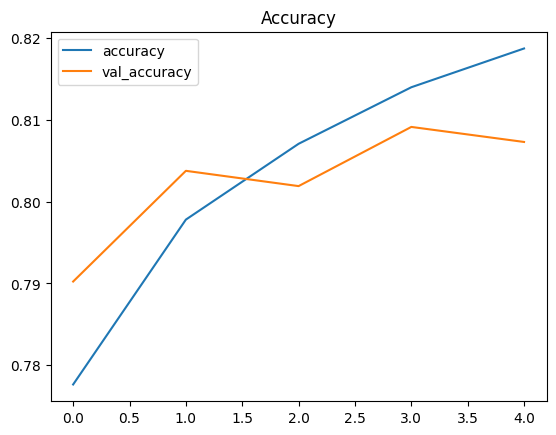

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = (pred > 0.5).astype(int).flatten()

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

595/595 [==============================] - 115s 192ms/step
Accuracy on the test set: 80.62%
